In [1]:
import os
import itertools
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
import xgboost as xgb

from feature_engineering import *

DATA_PATH = './data'
pd.options.mode.chained_assignment = None

%matplotlib inline

In [2]:
dtype_dict = {'object_id': 'int32', 'ddf': 'int8', 'target': 'int8', 'ra': 'float32', 'decl': 'float32', 
              'gal_l': 'float32', 'gal_b': 'float32'}
dtype_dict2 = {'object_id': 'int32', 'detected': 'int8', 'passband': 'int8', 'mjd': 'float32',
              'flux': 'float32', 'flux_err': 'float32'}

df_meta = pd.read_csv(os.path.join(DATA_PATH, 'training_set_metadata.csv'), dtype=dtype_dict)
df = pd.read_csv(os.path.join(DATA_PATH, 'training_set.csv'), dtype=dtype_dict2)

rename_target_dict = dict(zip(sorted(df_meta['target'].unique()), range(df_meta['target'].unique().shape[0])))
df_meta['target'] = df_meta['target'].map(rename_target_dict)

df = df.merge(df_meta, on='object_id')

w = df_meta['target'].value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}

In [3]:
def data_preprocessing(df):
    df['mag'] = np.abs(-2.5 * np.log10(df['flux']) - df['distmod'].fillna(0))
    df['mag2'] = np.abs(-2.5 * np.log10(df['flux'] - df.groupby('object_id')['flux'].transform('min') + 0.01)\
    - df['distmod'].fillna(0))

    df.loc[df['mag'] > 85, 'mag'] = np.nan
    df.loc[df['mag2'] > 85, 'mag2'] = np.nan

    df['flux_lt_zero'] = df.groupby('object_id')['flux'].transform(lambda x: x < -0.5)

    df['flux'] = df['flux'] * ((df['hostgal_photoz'] + 1) ** 2 )
    df['flux_err'] = df['flux_err'] * ((df['hostgal_photoz'] + 1) ** 2)

    df = df.drop(['ra', 'decl', 'gal_l', 'gal_b', 'mwebv', 'distmod', 'hostgal_specz'], axis=1)

    df['flux_ratio_sq'] = np.power((df['flux'] / df['flux_err']), 2)
    df['flux_by_flux_ratio_sq'] = df['flux_ratio_sq'] * df['flux']
    df['flux_higher_noise'] = df['flux_ratio_sq'] >= 1
    gc.collect()
    
    return df

def lgb_multi_weighted_logloss(y_true, y_preds):
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 
                    88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_p_log = np.log(y_p)
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

def multi_weighted_logloss(y_true, y_preds):
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 
                    88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_p_log = np.log(y_p)
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

def xgb_multi_weighted_logloss(y_predicted, y_true):
    loss = multi_weighted_logloss(y_true.get_label(), y_predicted)
    return 'wloss', loss

def train_lgb(full_train=None, y=None):
    res = []
    clfs = []
    importances = pd.DataFrame()
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=1000,
            early_stopping_rounds=75,
            sample_weight=trn_y.map(weights),
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        result = multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_))
        res.append(result)
        
        imp_df = pd.DataFrame()
        imp_df['feature'] = full_train.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0)
        clfs.append(clf)
        
    print('+' * 80)
    print(np.array(res).mean())
    print(np.array(res).std())
    return np.array(res).mean(), importances, oof_preds, clfs

def train_xgb(full_train, y):
    clfs = []
    
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]
    
        clf = xgb.XGBClassifier(**xgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=xgb_multi_weighted_logloss,
            verbose=100,
            early_stopping_rounds=75,
            sample_weight=trn_y.map(weights)
        )
        clfs.append(clf)

        oof_preds[val_, :] = clf.predict_proba(val_x, ntree_limit=clf.best_ntree_limit)
        print('no {}-fold loss: {}'.format(fold_ + 1, multi_weighted_logloss(val_y, oof_preds[val_, :])))

    score = multi_weighted_logloss(y_true=y, y_preds=oof_preds)
    print('MULTI WEIGHTED LOG LOSS: {:.5f}'.format(score))
    
    return clfs, score, oof_preds

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    
    plt.figure(figsize=(8, 24))
    sns.barplot(x='gain', y='feature', data=importances_.sort_values('mean_gain', ascending=False))
    plt.tight_layout()
    
def make_agg(df, aggs):
    temp = df.groupby(['object_id']).agg(aggs)
    temp.columns = temp.columns.map('_'.join)
    return temp

def make_agg_passband(df, aggs):
    temp = df.groupby(['object_id', 'passband']).agg(aggs)
    temp.columns = temp.columns.map('_'.join)
    
    temp = temp.unstack('passband')
    temp.columns = temp.columns.map('{0[0]}_{0[1]}'.format)   
    return temp

In [4]:
def feat_eng(df, df_meta):
    # for each object_id,  passband
    aggs = {'flux': [longest_strike_above_mean],
            'flux_higher_noise': ['mean'],
            'mag': ['max'],
            'flux_ratio_sq': ['mean']}

    temp = make_agg_passband(df, aggs)

    temp = pd.merge(temp.reset_index(), 
                    df_meta[['object_id', 'hostgal_photoz', 'hostgal_photoz_err']], 
                    on='object_id')
    gc.collect()
    
    # for each object_id
    aggs2 = {'flux': ['max', 'min', 'mean', 'skew', 'median', longest_strike_above_mean], 
             'detected': [longest_strike_above_mean],
             'flux_lt_zero': ['mean'],
             'mag': ['mean', 'skew'],
             'mag2': ['max', 'mean', 'skew'],
             'flux_higher_noise': ['mean'],
             'flux_by_flux_ratio_sq': ['mean', longest_strike_above_mean],
             'flux_ratio_sq': ['mean']}

    temp2 = make_agg(df, aggs2)

    temp2['flux_diff2'] = (temp2['flux_max'] - temp2['flux_min']) / temp2['flux_mean']
    temp2['flux_w_mean'] = temp2['flux_by_flux_ratio_sq_mean'] / temp2['flux_ratio_sq_mean']

    temp2.drop(['flux_min', 'flux_mean', 'flux_ratio_sq_mean', 'flux_by_flux_ratio_sq_mean',]
               , axis=1, inplace=True)

    temp = temp.merge(temp2.reset_index(), on='object_id')
    gc.collect()
    
    # for detected events
    df_det = df[df['detected'] == 1]
    
    group = df_det.groupby('object_id')
    temp2 = group['mjd'].apply(lambda x: np.ptp(x)).reset_index().rename(columns={'mjd': 'mjd_diff'})
    temp = pd.merge(temp, temp2, on='object_id')
    
    temp2 = df_det.groupby(['object_id', 'passband'])['mjd'].apply(lambda x: np.ptp(x)).unstack('passband')
    temp2.columns = ['mjd_diff_%s' % col for col in temp2.columns.tolist()]
    temp = pd.merge(temp, temp2.reset_index(), on='object_id')   
    
    gc.collect()
    
    # find parametr of peak
    out_col = ['vh', 'h', 'lhw', 'rhw', 'lw', 'rw', 'lrd', 'rrd', 'time', 'period']

    temp2 = df.groupby(['object_id', 'passband'])[['flux', 'flux_err', 'mjd']]\
    .apply(lambda x: pd.Series(make_peak_features(x)))
    temp2.columns = out_col
    temp2 = temp2.unstack()
    temp2.columns = temp2.columns.map('{0[0]}_{0[1]}'.format)   
    temp = pd.merge(temp, temp2.reset_index(), on='object_id')
    gc.collect()
    
    # smothed parameters of peaks
    temp2 = df.groupby('object_id')[['flux', 'flux_err', 'mjd']].\
    apply(lambda x: pd.Series(smoth_light_curve(x)))
    temp2.columns = [col + '_smth' for col in out_col] + ['flux_cid_ce_smth']
    temp = pd.merge(temp, temp2.reset_index(), on='object_id')
    gc.collect()
    
    
    # mean for passbands
    for col in ['vh', 'h', 'lhw', 'rhw', 'lw', 'rw', 'lrd', 'rrd']:
        temp[col + '_mean'] = temp[[col + '_' + str(i) for i in range(6)]].mean(axis=1)

    temp['time_mean'] = temp[['time_%i' % i for i in range(6)]].mean(axis=1)
    for i in range(6):
        temp['time_changed_%i' % i] = np.abs(temp['time_%i' % i] - temp['time_mean'])

    temp['time_mean'] = temp[['time_changed_%i' % i for i in range(6)]].mean(axis=1)

    temp.drop(['time_changed_%i' % i for i in range(6)] + ['time_%i' % i for i in range(6)] +\
              ['vh_%i' % i for i in range(6)] + ['h_%i' % i for i in range(6)]+\
              ['period_%i' % i for i in range(6)]
              , axis=1, inplace=True)

    gc.collect()
    
    # sum half width and width
    temp['sum_w_smth'] = temp['lw_smth'] + temp['rw_smth']
    temp['sum_hw_mean'] = temp['lhw_mean'] + temp['rhw_mean']
    
    # find passband with max magnitude
    temp['mag_max_pos'] = temp[['mag_max_%i' % i for i in range(6)]].apply(lambda x: x.values.argmax(), axis=1)
    
    for pos in range(1, 6):
        temp['mag_max_pos_%i' % pos] = temp[['mag_max_%i' % i for i in range(6)]]\
        .apply(lambda x: x.values.argsort()[-1-pos], axis=1)
    
    temp['mag_max_scaled_mean'] = temp[['mag_max_%i' % i for i in range(6)]].apply(lambda x: x/x.max(), axis=1)\
    .mean(axis=1)
    temp['mag_max_scaled_std'] = temp[['mag_max_%i' % i for i in range(6)]].apply(lambda x: x/x.max(), axis=1)\
    .std(axis=1)
        
    # find wavelength  on which light was emitted
    from_channel_to_nm = {0: 360, 1: 475, 2: 620, 3:755, 4:865, 5:974}
    temp['true_mag_max'] = temp['mag_max_pos'].map(from_channel_to_nm) / (1 + temp['hostgal_photoz'])
    temp.loc[(temp['hostgal_photoz_err'] / (temp['hostgal_photoz'] + 0.01)) >= 0.35, 'true_mag_max'] = 0
    temp['true_mag_max'] = pd.cut(temp['true_mag_max'], range(-1, 1000, 75), right=True, labels=range(13))
    
    for col in ['lrd_smth', 'rrd_smth', 'lrd_mean', 'rrd_mean']:
        temp[col] = np.log(temp[col] + 1)
    
    temp.drop(['rrd_%i' % i for i in range(6)] + ['lrd_%i' % i for i in range(6)] +\
              ['flux_ratio_sq_mean_%i' % i for i in range(6)] +\
              ['flux_longest_strike_above_mean_%i' % i for i in range(6)] +\
              ['lhw_%i' % i for i in range(6)] + ['rhw_%i' % i for i in range(6)] +\
              ['vh_smth', 'h_smth', 'time_smth', 'rhw_mean',] 
              , axis=1, inplace=True)
    
    return temp

In [5]:
%%time
df = data_preprocessing(df)
temp = feat_eng(df, df_meta)

CPU times: user 5min 5s, sys: 640 ms, total: 5min 6s
Wall time: 5min 5s


In [7]:
temp = temp.merge(df_meta[['object_id', 'target']], on='object_id')

In [12]:
df['flux_lt_zero'] = df.groupby('object_id')['flux'].transform(lambda x: x < -0.5)
temp2 = df.groupby('object_id')['flux_lt_zero'].mean()
temp = temp.merge(temp2.reset_index(), on='object_id')

In [9]:
to_remove = [

]

In [10]:
all_columns = temp.columns.tolist()
all_columns.remove('object_id')
all_columns.remove('target')

for col in to_remove:
    all_columns.remove(col)
len(all_columns)

76

In [11]:
all_columns

['flux_higher_noise_mean_0',
 'flux_higher_noise_mean_1',
 'flux_higher_noise_mean_2',
 'flux_higher_noise_mean_3',
 'flux_higher_noise_mean_4',
 'flux_higher_noise_mean_5',
 'mag_max_0',
 'mag_max_1',
 'mag_max_2',
 'mag_max_3',
 'mag_max_4',
 'mag_max_5',
 'hostgal_photoz',
 'hostgal_photoz_err',
 'flux_by_flux_ratio_sq_longest_strike_above_mean',
 'flux_higher_noise_mean',
 'flux_lt_zero_mean',
 'mag2_max',
 'mag2_mean',
 'mag2_skew',
 'flux_max',
 'flux_skew',
 'flux_median',
 'flux_longest_strike_above_mean',
 'detected_longest_strike_above_mean',
 'mag_mean',
 'mag_skew',
 'flux_diff2',
 'flux_w_mean',
 'mjd_diff',
 'mjd_diff_0',
 'mjd_diff_1',
 'mjd_diff_2',
 'mjd_diff_3',
 'mjd_diff_4',
 'mjd_diff_5',
 'lw_0',
 'lw_1',
 'lw_2',
 'lw_3',
 'lw_4',
 'lw_5',
 'rw_0',
 'rw_1',
 'rw_2',
 'rw_3',
 'rw_4',
 'rw_5',
 'lhw_smth',
 'rhw_smth',
 'lw_smth',
 'rw_smth',
 'lrd_smth',
 'rrd_smth',
 'period_smth',
 'flux_cid_ce_smth',
 'vh_mean',
 'h_mean',
 'lhw_mean',
 'lw_mean',
 'rw_mean',


In [13]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=16)
clfs = []
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 14,
    'metric': 'multi_logloss',
    'learning_rate': 0.03,
    'subsample': .9,
    'colsample_bytree': .7,
    'reg_alpha': .01,
    'reg_lambda': .01,
    'min_split_gain': 0.01,
    'min_child_weight': 10,
    'n_estimators': 1000,
    'silent': 1,
    'verbose': -1,
    'max_depth': 3,
}

In [14]:
m, imp, oof, clfs = train_lgb(temp[all_columns], temp['target'])

Training until validation scores don't improve for 75 rounds.
Early stopping, best iteration is:
[493]	training's multi_logloss: 0.203963	training's wloss: 0.19353	valid_1's multi_logloss: 0.594013	valid_1's wloss: 0.547051
Training until validation scores don't improve for 75 rounds.
Early stopping, best iteration is:
[431]	training's multi_logloss: 0.225094	training's wloss: 0.214941	valid_1's multi_logloss: 0.625777	valid_1's wloss: 0.556769
Training until validation scores don't improve for 75 rounds.
Early stopping, best iteration is:
[552]	training's multi_logloss: 0.187539	training's wloss: 0.177589	valid_1's multi_logloss: 0.581338	valid_1's wloss: 0.517571
Training until validation scores don't improve for 75 rounds.
Early stopping, best iteration is:
[472]	training's multi_logloss: 0.211603	training's wloss: 0.201289	valid_1's multi_logloss: 0.610561	valid_1's wloss: 0.550849
Training until validation scores don't improve for 75 rounds.
Early stopping, best iteration is:
[553

In [15]:
gc.collect()

440

In [16]:
preds_oof = pd.DataFrame(oof, columns=['class_' + str(s) for s in clfs[0].classes_])
preds_oof.to_csv('oof/lgb_001.csv', float_format='%.6f')

Normalized confusion matrix


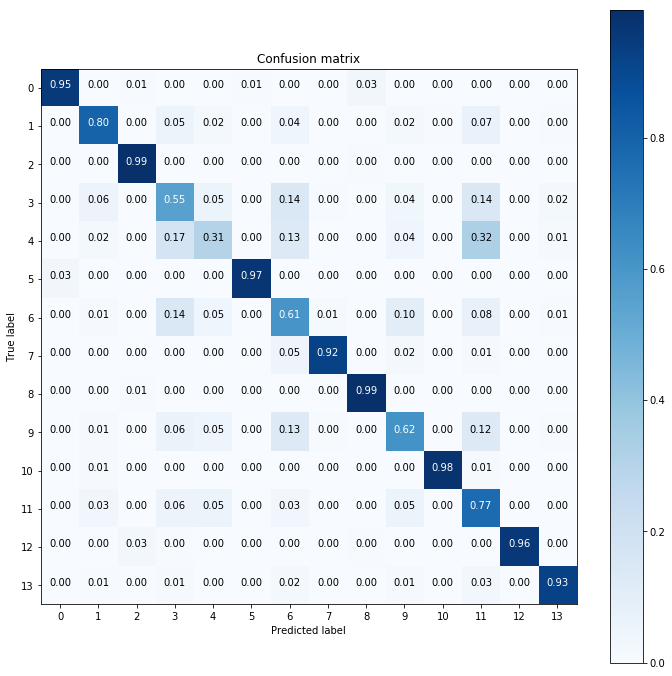

In [17]:
cnf_matrix = confusion_matrix(temp['target'], np.argmax(oof, axis=-1))
np.set_printoptions(precision=2)


# Plot normalized confusion matrix
plt.figure(figsize=(12, 12))
foo = plot_confusion_matrix(cnf_matrix, classes=range(14), normalize=True,
                      title='Confusion matrix')

/usr/local/lib/python3.4/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


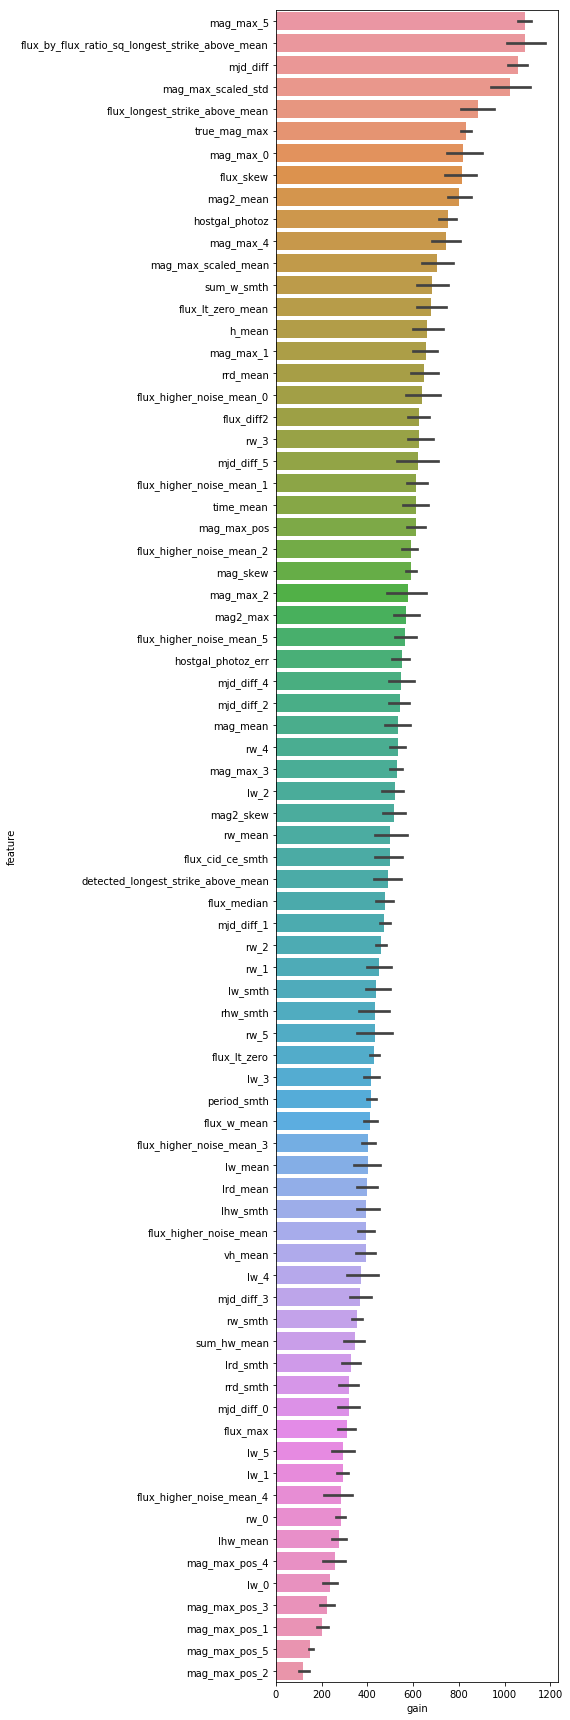

In [18]:
save_importances(imp)

In [20]:
def predict_chunk(df, clfs_, meta_, features):

    df = df.merge(meta_, on='object_id')
    
    df = data_preprocessing(df)
    
    full_test = feat_eng(df, meta_)

    # Make predictions
    preds_ = None
    for clf in clfs_:
        if preds_ is None:
            preds_ = clf.predict_proba(full_test[features]) / len(clfs_)
        else:
            preds_ += clf.predict_proba(full_test[features]) / len(clfs_)

    # Compute preds_99 as the proba of class not being any of the others
    preds_99 = np.ones(preds_.shape[0])
    for i in range(preds_.shape[1]):
        preds_99 *= (1 - preds_[:, i])
        
    # write prepared data
#     fill_test.to_csv(os.path.join(DATA_PATH, 'test_data_batch_%i' % i), index=False)
#     full_test['target'] = preds_.argmax(axis=1)
#     full_test['prob'] = np.amax(preds_, axis=1)

    # Create DataFrame from predictions
    preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs_[0].classes_])
    preds_df_['object_id'] = full_test['object_id']
    preds_df_['class_99'] = 0.23 * preds_99 / np.mean(preds_99) 

    del df, preds_
    gc.collect()

    return preds_df_, full_test

In [21]:
meta_test = pd.read_csv(os.path.join(DATA_PATH, 'test_set_metadata.csv'))

chunks = 500000
remain_df = None
test_data = None

def the_unique(x):
    return [x[i] for i in range(len(x)) if x[i] != x[i-1]]

for i_c, df in enumerate(pd.read_csv(os.path.join(DATA_PATH, 'test_set.csv'), chunksize=chunks, iterator=True)):
    unique_ids = the_unique(df['object_id'].tolist())
    new_remain_df = df.loc[df['object_id'] == unique_ids[-1]].copy()

    if remain_df is None:
        df = df.loc[df['object_id'].isin(unique_ids[:-1])].copy()
    else:
        df = pd.concat([remain_df, df.loc[df['object_id'].isin(unique_ids[:-1])]], axis=0)

    
    remain_df = new_remain_df

    preds_df, data  = predict_chunk(df=df, clfs_=clfs, meta_=meta_test, features=all_columns)
    
    if test_data is None:
        test_data = data
    else:
        test_data = pd.concat([test_data, data], axis=0)

    if i_c == 0:
        preds_df.to_csv('predictions.csv', header=True, index=False, float_format='%.6f')
    else:
        preds_df.to_csv('predictions.csv', header=False, mode='a', index=False, float_format='%.6f')

    del preds_df
    gc.collect()
    

preds_df, data = predict_chunk(df=df, clfs_=clfs, meta_=meta_test, features=all_columns)

if test_data is None:
    test_data = data
else:
    test_data = pd.concat([test_data, data], axis=0)

test_data.to_csv('preprocessed_test_set.csv', index=False)

preds_df.to_csv('predictions.csv', header=False, mode='a', index=False, float_format='%.6f')

z = pd.read_csv('predictions.csv')

z = z.groupby('object_id').mean()

z.to_csv('model_to_stack/lgb_model_001.csv', index=True, float_format='%.6f', compression='gzip')